In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
os.chdir('data')
#from colorsetup import colors, palette
plt.style.use('fivethirtyeight')
#sns.set_palette(palette)
import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# SIMPLE RNN

In [5]:
df_Beijing = pd.read_csv('./FiveCitiesPM/Beijing.csv') #di folder data
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(9)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0


In [7]:
df_Beijing.shape

(8760, 18)

In [8]:
df_Beijing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 43824 to 52583
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   No               8760 non-null   int64  
 1   year             8760 non-null   int64  
 2   month            8760 non-null   int64  
 3   day              8760 non-null   int64  
 4   hour             8760 non-null   int64  
 5   season           8760 non-null   int64  
 6   PM_Dongsi        8596 non-null   float64
 7   PM_Dongsihuan    5465 non-null   float64
 8   PM_Nongzhanguan  8473 non-null   float64
 9   PM_US Post       8631 non-null   float64
 10  DEWP             8755 non-null   float64
 11  HUMI             8421 non-null   float64
 12  PRES             8421 non-null   float64
 13  TEMP             8755 non-null   float64
 14  cbwd             8755 non-null   object 
 15  Iws              8755 non-null   float64
 16  precipitation    8301 non-null   float64
 17  Iprec    

In [10]:
df_Beijing.isnull().sum()

No                    0
year                  0
month                 0
day                   0
hour                  0
season                0
PM_Dongsi           164
PM_Dongsihuan      3295
PM_Nongzhanguan     287
PM_US Post          129
DEWP                  5
HUMI                339
PRES                339
TEMP                  5
cbwd                  5
Iws                   5
precipitation       459
Iprec               459
dtype: int64

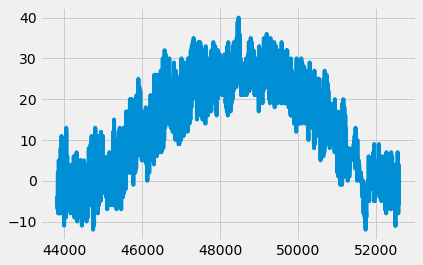

In [9]:
plt.plot(df_Beijing['TEMP'])

In [11]:
df_Beijing['PM_Dongsi'] = df_Beijing.PM_Dongsi.interpolate()
df_Beijing['TEMP'] = df_Beijing['TEMP'].interpolate()
df_Beijing['PM_Dongsi'].head(10)

43824    5.0
43825    4.0
43826    3.0
43827    4.0
43828    3.0
43829    3.0
43830    3.0
43831    3.0
43832    4.0
43833    5.0
Name: PM_Dongsi, dtype: float64

In [12]:
df_Beijing.isna().sum()

No                    0
year                  0
month                 0
day                   0
hour                  0
season                0
PM_Dongsi             0
PM_Dongsihuan      3295
PM_Nongzhanguan     287
PM_US Post          129
DEWP                  5
HUMI                339
PRES                339
TEMP                  0
cbwd                  5
Iws                   5
precipitation       459
Iprec               459
dtype: int64

In [13]:
def make_date(row):
    return datetime(year = row['year'], month = row['month'], day = row['day'], hour = row['hour'])
df_Beijing['date'] = df_Beijing.apply(make_date,axis=1)
df_Beijing.set_index(df_Beijing.date,inplace=True)

<AxesSubplot:xlabel='date'>

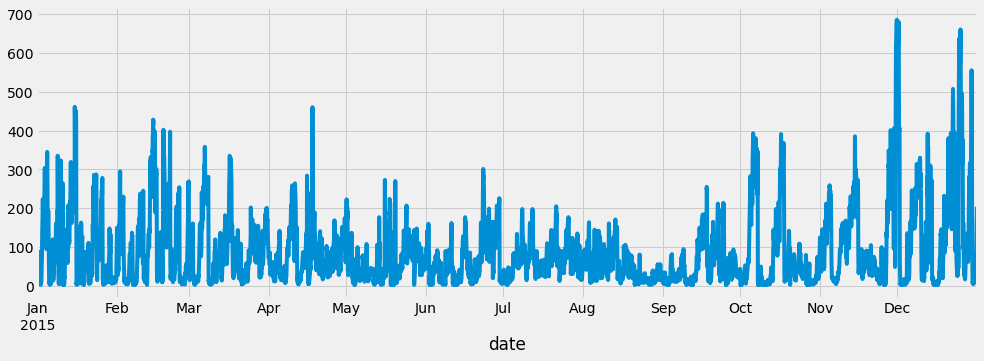

In [14]:
#quick plot of full time series
plt.figure(figsize = (15,5))
df_Beijing['PM_Dongsi'].plot()

In [15]:
df_Beijing['PM_Dongsi']

date
2015-01-01 00:00:00      5.0
2015-01-01 01:00:00      4.0
2015-01-01 02:00:00      3.0
2015-01-01 03:00:00      4.0
2015-01-01 04:00:00      3.0
                       ...  
2015-12-31 19:00:00    140.0
2015-12-31 20:00:00    157.0
2015-12-31 21:00:00    171.0
2015-12-31 22:00:00    204.0
2015-12-31 23:00:00    204.0
Name: PM_Dongsi, Length: 8760, dtype: float64

In [18]:
df_Beijing.head(2)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,date
date,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0,2015-01-01 00:00:00
2015-01-01 01:00:00,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0,2015-01-01 01:00:00


In [17]:
df_Beijing.PM_Dongsi

date
2015-01-01 00:00:00      5.0
2015-01-01 01:00:00      4.0
2015-01-01 02:00:00      3.0
2015-01-01 03:00:00      4.0
2015-01-01 04:00:00      3.0
                       ...  
2015-12-31 19:00:00    140.0
2015-12-31 20:00:00    157.0
2015-12-31 21:00:00    171.0
2015-12-31 22:00:00    204.0
2015-12-31 23:00:00    204.0
Name: PM_Dongsi, Length: 8760, dtype: float64

In [19]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-(24*n_days):] 

def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series 
    """
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} Air Quality Time Series - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded Hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

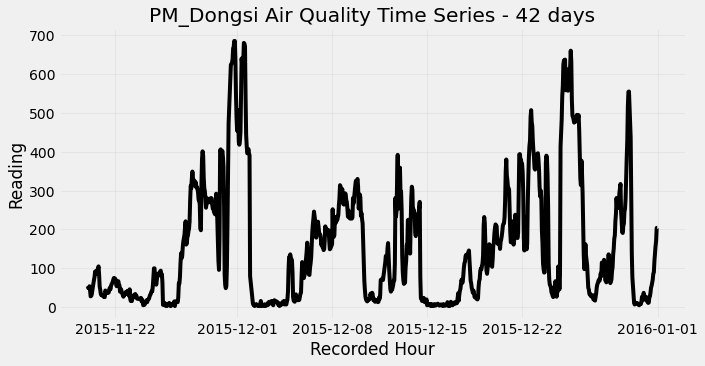

In [20]:
plot_n_last_days(df_Beijing, 'PM_Dongsi', 42)

In [26]:
df_Beijing['PM_Dongsi'][-3:]

date
2015-12-31 21:00:00    171.0
2015-12-31 22:00:00    204.0
2015-12-31 23:00:00    204.0
Name: PM_Dongsi, dtype: float64

In [27]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

In [28]:
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days, 
                         input_hours, test_hours))

In [29]:
train_y.shape

(436,)

In [30]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (436, 12, 1)
Training output shape: (436,)
Test input shape: (12,)
Test output shape: (12,)


In [31]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

In [32]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

In [33]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

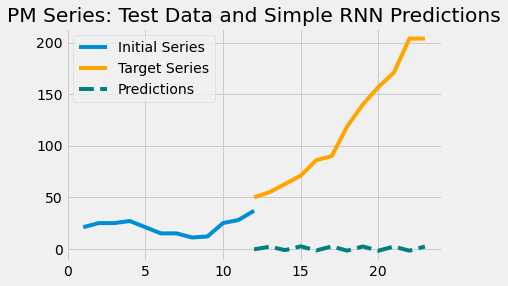

In [34]:
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

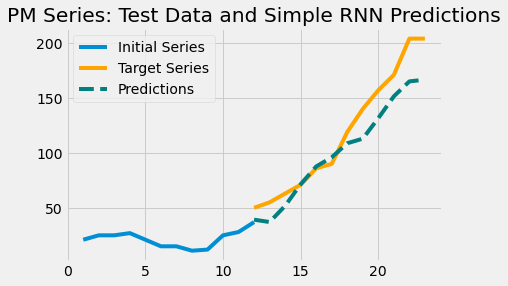

In [40]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

In [41]:
df_Beijing['PM_Nongzhanguan'] = df_Beijing['PM_Nongzhanguan'].interpolate()
df_Beijing['PM_Nongzhanguan'].head(10)

date
2015-01-01 00:00:00     8.0
2015-01-01 01:00:00     7.0
2015-01-01 02:00:00     7.0
2015-01-01 03:00:00    11.0
2015-01-01 04:00:00     5.0
2015-01-01 05:00:00     3.0
2015-01-01 06:00:00     6.0
2015-01-01 07:00:00     7.0
2015-01-01 08:00:00     9.0
2015-01-01 09:00:00    11.0
Name: PM_Nongzhanguan, dtype: float64

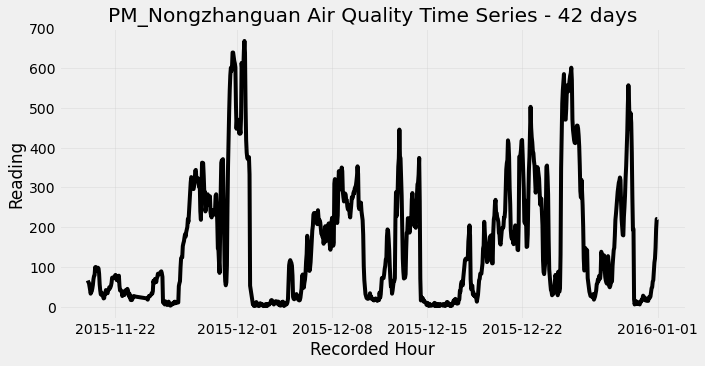

In [42]:
plot_n_last_days(df_Beijing, 'PM_Nongzhanguan', 42)

In [43]:
series_days = 56
input_hours = 6
test_hours = 12

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

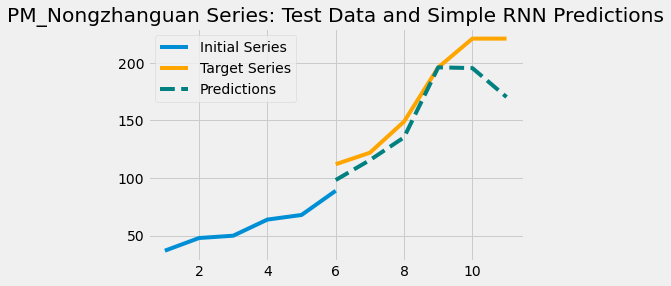

In [55]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1800)

predict_and_plot(test_X_init, test_y, model, 
                 'PM_Nongzhanguan Series: Test Data and Simple RNN Predictions')

In [71]:
test_X_init.reshape(1,-1,1)

array([[[112.],
        [130.],
        [ 99.],
        [ 76.],
        [ 67.],
        [ 62.],
        [ 59.],
        [ 89.],
        [128.],
        [112.],
        [ 53.],
        [ 50.]]])

In [72]:
model.predict(test_X_init.reshape(1,-1,1))

array([[46.39695]], dtype=float32)

In [64]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_18 (SimpleRNN)    (None, 30)                960       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 31        
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


# LSTM

In [65]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

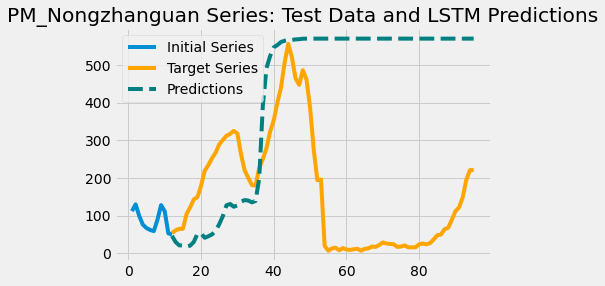

In [66]:
series_days = 50 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000) 

predict_and_plot(test_X_init, test_y, model, 
                 'PM_Nongzhanguan Series: Test Data and LSTM Predictions')

In [67]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 70)                20160     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________
